In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tree import Tree

# The Exp3 Algorithm

\begin{aligned}
&\textbf{Input: } n, k, \eta \\
&\text{Set } \hat{S}_i^0 = 0 \text{ for all } i \in \{1, \dots, k\} \\
&\textbf{for } t = 1, \dots, n \textbf{ do} \\
&\quad \text{Calculate the sampling distribution } P_t: \\
&\quad \quad P_{i,t} = \frac{\exp\left(\eta \hat{S}_i^{t-1}\right)}{\sum_{j=1}^k \exp\left(\eta \hat{S}_j^{t-1}\right)} \\
&\quad \text{Sample } A_t \sim P_t \text{ and observe reward } X_t \\
&\quad \text{Update } \hat{S}_i^t \text{ accordingly.} : \hat{S}_i^t = \hat{S}_i^{t-1} + \frac{X_t}{P_{i,t}}\\
&\textbf{end for}
\end{aligned}


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


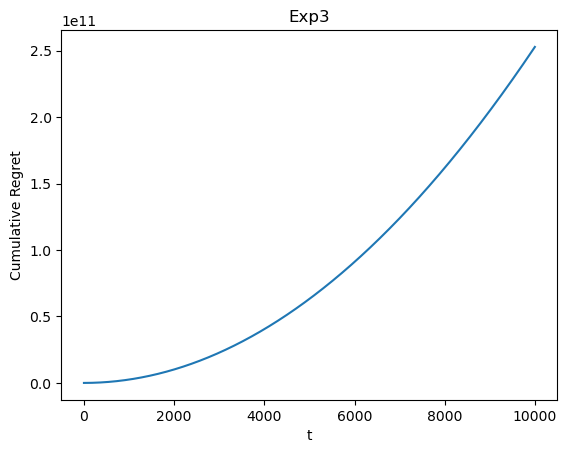

In [13]:
class Exp3:
    def __init__(self, K, eta, n):
        self.K = K
        self.eta = eta
        self.n = n
        self.S_hat = np.zeros(K)
        self.P_hat = np.ones(K) / K

    def update(self, xt, index_arm):
        self.S_hat[index_arm] += xt / self.P_hat[index_arm]   
        self.P_hat = np.exp(self.eta * self.S_hat) / np.sum(np.exp(self.eta * self.S_hat))
    
    def select_arm(self):
        return np.random.choice(self.K, p = self.P_hat)
    
    def run(self, rewards):
        regret = np.zeros(self.n)
        for t in range(self.n):
            index_arm = self.select_arm()
            reward = rewards[t, index_arm]
            self.update(reward, index_arm)
            regret[t] = np.max(np.sum(rewards, axis = 0)) - reward
        regret = np.cumsum(regret)
        return regret
    
def main():
    K = 6
    n = 10 ** 4
    T = 10 ** 2
    eta = np.sqrt(2 * np.log(K) / (n * K))
    rewards = np.random.binomial(1, 0.5, (n, K))
    regret = np.zeros((T, n))
    for t in tqdm(range(T)):
        exp3 = Exp3(K, eta, n)
        regret[t] = exp3.run(rewards)
    regret = np.mean(regret, axis = 0)
    plt.plot(np.cumsum(regret))
    plt.xlabel('t')
    plt.ylabel('Cumulative Regret')
    plt.title('Exp3')
    plt.show()

if __name__ == '__main__':
    main()

# The NEW algorithm 

$\textbf{Algorithm: Nested Exponential Weights (NEW)}$

\begin{aligned}
&\textbf{Require:} \quad \mathcal{A}: \text{Set of alternatives}, \; \mathcal{S} = \{S_l\}_{l=1}^L: \text{Attribute structure}, \; \mu = \{\mu_1, \dots, \mu_L\} > 0, \; \eta_t \geq 0: \text{Learning rate}, \; n: \text{Number of iterations} \\
&\textbf{Input:} \quad \{r_t\}_{t=1}^n \in [0,1]^{\mathcal{S}}: \text{Sequence of costs} \\
&\textbf{Initialize:} \quad y \leftarrow 0 \in \mathbb{R}^{\mathcal{A}}, \; \hat{S} \leftarrow \{0 \; \forall \; S \in \mathcal{S}\} \\
&\textbf{For } t = 1, \dots, n \textbf{ do:} \\
&\quad \textbf{Scoring Phase:} \\
&\quad \textbf{For } l = L-1 \textbf{ to } 0 \textbf{ do:} \\
&\quad \quad \textbf{For each } S \in S_l: \\
&\quad \quad \quad y_S \leftarrow \mu_{l+1} \cdot \log \left( \sum_{S' \subseteq S} \exp \left( \frac{y_{S'}}{\mu_{l+1}} \right) \right) \\
&\quad \quad \quad \hat{S}[S] \leftarrow 0 \; \text{(Reset baseline guess for class } S\text{)} \\
&\quad \textbf{Selection Phase:} \\
&\quad \textbf{For } l = 1 \textbf{ to } L \textbf{ do:} \\
&\quad \quad \textbf{For each } S \in S_l: \\
&\quad \quad \quad P(S) \leftarrow \frac{\exp \left( \eta_t \cdot \frac{y_S}{\mu_l} \right)}{\sum_{S \in S_l} \exp \left( \eta_t \cdot \frac{y_S}{\mu_l} \right)} \\
&\quad \quad \quad \text{Sample } S \sim P(S) \\
&\quad \quad \quad \text{Observe reward } r_{S,t} \\
&\quad \quad \quad \hat{S}[S] \leftarrow \hat{S}[S] + r_{S,t} \; \text{(Update rewards for class } S\text{)} \\
&\quad \textbf{Update Propensities:} \\
&\quad \textbf{For each } a \in \mathcal{A}: \\
&\quad \quad \hat{c}[a] \leftarrow \sum_{S \ni a} \hat{S}[S] \\
&\quad \quad y[a] \leftarrow y[a] - \hat{c}[a] \\
&\textbf{End For} \\
&\textbf{Output:} \quad \text{Cumulative regret, Updated propensity scores}
\end{aligned}




In [ ]:
class NEW:
    def __init__(self, A, S, mu, eta, n):
        """
        A: Set of alternatives
        S: Attribute structure (list of levels Sl) 
        mu: List of uncertainty levels μ1, ..., μL > 0
        eta: Learning rate ηt
        n: Number of iterations
        """
        self.A = A
        self.S = S
        self.indices = S.assign_indices()
        self.mu = mu   # we consider mu as fixed for simplicity
        self.eta = eta    # we consider eta as fixed for simplicity
        self.n = n
        self.y = np.zeros(len(A))
        self.r_hat = np.zeros(len(self.S.get_all_nodes()))

    def run(self, costs):
        regret = np.zeros(self.n)
        for t in range(self.n):
            # scoring phase 
            self.scoring_phase()

            # selection phase
            self.selection_phase(costs[t])

            # loss model
            


    def scoring_phase(self):
        # Get all nodes in reverse order of levels
        nodes = self.S.get_all_nodes()
        nodes_by_level = sorted(nodes, key=lambda x: -x.level)

        # Iterate through levels from L-1 to 0
        for node in nodes_by_level:
            if node.children:
                # Compute y_S using children scores
                exp_scores = np.array([np.exp(child.value / self.mu) for child in node.children])
                log_sum_exp = np.log(exp_scores.sum())
                node.value = self.mu * log_sum_exp + self.mu
            
    
    def selection_phase(self, cost):
        path = []
        current_node = self.S.root

        while current_node.children:
            # Compute probabilities for current node's children
            children = current_node.children
            scores = np.array([child.value for child in children])
            exp_scores = np.exp(self.eta * scores / self.mu)
            probabilities = exp_scores / exp_scores.sum()

            # Select child based on probabilities
            selected_index = np.random.choice(len(children), p = probabilities)
            selected_node = children[selected_index]
            indice_cost = self.indices[selected_node.name]
            r = cost[indice_cost]
            self.r_hat[indice_cost] = r
            # Update path and current node
            path.append(selected_node.name)
            current_node = selected_node

        return path
        



def main():
    A = np.arange(6)  # Alternatives : "short vma", "hills", "threshold", "fartleck", "cold water", "footing"
    S = Tree()
    root = S.insert(None, ('Training', 0.0))
    SPEED, _ = S.insert(root, ('SPEED', 0.0))
    ENDURANCE, _ = S.insert(root, ('ENDURANCE', 0.0))
    RECUPERATION, _ = S.insert(root, ('RECUPERATION', 0.0))
    S.insert(SPEED, ('short vma', 0.5))
    S.insert(SPEED, ('hills', 0.5))
    S.insert(ENDURANCE, ('threshold', 0.8))
    S.insert(ENDURANCE, ('fartleck', 0.3))
    S.insert(RECUPERATION, ('cold water', 0.1))
    S.insert(RECUPERATION, ('footing', 0.6))
    print(S.assign_indices())
    L = 2
    n_l = 2
    Rl_bar = 1    # We assume R_S = 1
    n_eff = (L * np.sqrt(n_l) * Rl_bar) ** 2
    mu = np.sqrt(n_eff / 2)     # sqrt(n_eff / 2)
    n = 10 ** 4  # Number of iterations
    T = 10 ** 2  # Number of simulations
    eta = 0.1  # Learning rate
    rewards = np.random.uniform(0, 1, size = (n, len(A)))  # Random costs in [0,1]
    regret = np.zeros((T, n))
    for t in tqdm(range(T)):
        new_algorithm = NEW(A, S, mu, eta, n)
        regret[t] = new_algorithm.run(rewards)
    
    avg_regret = np.mean(regret, axis=0)
    plt.plot(avg_regret)
    plt.xlabel('t')
    plt.ylabel('Cumulative Regret')
    plt.title('NEW Algorithm')
    plt.show()

if __name__ == "__main__":
    main()

In [6]:
S = Tree()
root = S.insert(None, ('Training', 0.0))
SPEED, _ = S.insert(root, ('SPEED', 0.0))
ENDURANCE, _ = S.insert(root, ('ENDURANCE', 0.0))
RECUPERATION, _ = S.insert(root, ('RECUPERATION', 0.0))
S.insert(SPEED, ('short vma', 0.5))
S.insert(SPEED, ('hills', 0.5))
S.insert(ENDURANCE, ('threshold', 0.8))
S.insert(ENDURANCE, ('fartleck', 0.3))
S.insert(RECUPERATION, ('cold water', 0.1))
S.insert(RECUPERATION, ('footing', 0.6))
dico = S.assign_indices()


0

In [40]:
n_iterations = 10 ** 4
L = 2
n_l = 2
Rl_bar = 1    # We assume R_S = 1
n_eff = (L * np.sqrt(n_l) * Rl_bar) ** 2
mu = np.sqrt(n_eff / 2)     # sqrt(n_eff / 2)
regret = []
cumulative_regret = 0

for t in range(1, n_iterations + 1):
    eta = np.sqrt(np.log(n_iterations) / (2 * t))  # Theorem 
    
    # Backward phase 
    for layer in range(L, 0, -1):
        if layer == L:
            pass  # No need to update scores of intervals at this step
        else:  # Update scores of the types
            for index, type in enumerate(["SPEED", "ENDURANCE", "RECUPERATION"]): 
                sub_intervals, indx = return_intervals(index)
                sub_scores = scores_interval[index, indx]
                scores_type[index] = mu * np.log(
                    np.sum(np.exp(sub_scores / mu))
                )
    
    scores_type = normalize(scores_type)
    # End of backward phase 

    r_hat = np.zeros((len(type_training), len(interval)))
    
    # Forward phase
    # Select class of layer 1
    prob_type = softmax(scores_type, mu)
    idx_type = np.random.choice(len(type_training), p=prob_type)
    selected_training = type_training[idx_type]
    score_selected_training = scores_type[idx_type]

    # Select class of layer 2
    name_intervals, idx = return_intervals(idx_type)
    sub_intervals = scores_interval[idx_type, idx]
    prob_interval_layer_2_selected = np.exp(eta * sub_intervals / mu)
    prob_interval_layer_2_selected /= np.sum(prob_interval_layer_2_selected)
    idx_interval = np.random.choice(len(sub_intervals), p=prob_interval_layer_2_selected)
    r = simulate_reward(selected_training, name_intervals[idx_interval])
    r_hat[idx_type, idx[idx_interval]] += r / prob_interval_layer_2_selected[idx_interval]
    # End of forward phase
    
    # Update scores
    for idx_type in range(len(type_training)):
        name_intervals, idx = return_intervals(idx_type)
        for local_idx, global_idx in enumerate(idx):
            scores_interval[idx_type, global_idx] -= r_hat[idx_type, global_idx]
    
    # Normalize scores
    for idx_type in range(len(type_training)):
        scores_interval[idx_type] = normalize(scores_interval[idx_type])

    # Regret 
    optimal_reward = optimal_rewards[selected_training]
    cumulative_regret += (optimal_reward - r)
    regret.append(cumulative_regret)

# Résultats finaux
print("Final scores of trainings:")
for i, type in enumerate(type_training):
    print(f"{type}: {scores_type[i]:.2f}")

print("\nFinal scores of intervals:")
for i, type in enumerate(type_training):
    sub_intervals, idx = return_intervals(i)
    for local_idx, global_idx in enumerate(idx):
        print(f"{type} - {sub_intervals[local_idx]}: {scores_interval[i, global_idx]:.2f}")

Final scores of trainings:
SPEED: 1.00
ENDURANCE: 0.68
RECUPERATION: 0.00

Final scores of intervals:
SPEED - short vma: 0.00
SPEED - hills: 1.00
ENDURANCE - threshold: 0.90
ENDURANCE - fatleck: 0.00
RECUPERATION - cold water: 0.74
RECUPERATION - footing: 0.00


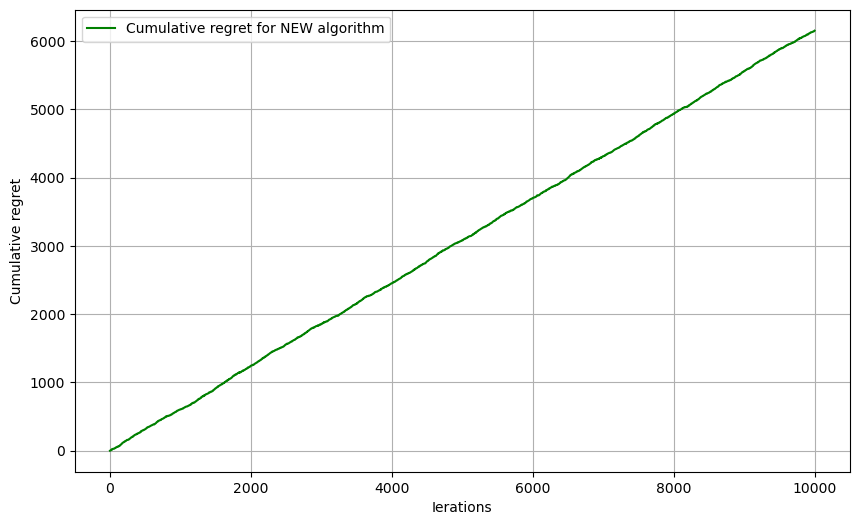

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations + 1), regret, label = "Cumulative regret for NEW algorithm", color = "green")
plt.xlabel("Ierations")
plt.ylabel("Cumulative regret")
plt.legend()
plt.grid()
plt.show()

Problèmes : 
- L'algorithme discrimine mal lorsqu'une solution est vraiment optimale. 
- Nécessité de connaître la structure. 